<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/CNN_Multiclass_Transfer_Learning_Birds_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopdl

In [4]:
!cp /content/kaggle.json /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d gpiosenka/100-bird-species

 98% 851M/871M [00:04<00:00, 230MB/s]
100% 871M/871M [00:04<00:00, 210MB/s]


In [ ]:
!unzip /content/100-bird-species.zip

In [24]:
import torch
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [34]:
bs = 128
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder("/content/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("/content/valid/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

val_set = datasets.ImageFolder("/content/test/", transform=test_transform)
valloader = DataLoader(val_set, shuffle=True)

In [19]:
label2cat = train_set.classes
label2cat, len(label2cat)

(['AFRICAN CROWNED CRANE',
  'AFRICAN FIREFINCH',
  'ALBATROSS',
  'ALEXANDRINE PARAKEET',
  'AMERICAN AVOCET',
  'AMERICAN BITTERN',
  'AMERICAN COOT',
  'AMERICAN GOLDFINCH',
  'AMERICAN KESTREL',
  'AMERICAN PIPIT',
  'AMERICAN REDSTART',
  'ANHINGA',
  'ANNAS HUMMINGBIRD',
  'ANTBIRD',
  'ARARIPE MANAKIN',
  'ASIAN CRESTED IBIS',
  'BALD EAGLE',
  'BALI STARLING',
  'BALTIMORE ORIOLE',
  'BANANAQUIT',
  'BANDED BROADBILL',
  'BAR-TAILED GODWIT',
  'BARN OWL',
  'BARN SWALLOW',
  'BARRED PUFFBIRD',
  'BAY-BREASTED WARBLER',
  'BEARDED BARBET',
  'BEARDED REEDLING',
  'BELTED KINGFISHER',
  'BIRD OF PARADISE',
  'BLACK & YELLOW bROADBILL',
  'BLACK FRANCOLIN',
  'BLACK SKIMMER',
  'BLACK SWAN',
  'BLACK TAIL CRAKE',
  'BLACK THROATED BUSHTIT',
  'BLACK THROATED WARBLER',
  'BLACK VULTURE',
  'BLACK-CAPPED CHICKADEE',
  'BLACK-NECKED GREBE',
  'BLACK-THROATED SPARROW',
  'BLACKBURNIAM WARBLER',
  'BLUE GROUSE',
  'BLUE HERON',
  'BOBOLINK',
  'BORNEAN BRISTLEHEAD',
  'BORNEAN LEAFBIRD

In [16]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 224, 224])

In [17]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()

    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, output_size),
        nn.LogSoftmax(1)
    )

  def forward(self, x):
    return self.mnet(x)
  
  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [18]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size,
    'output_size': len(train_set.classes)
})

In [20]:
model = CustomMobileNetv2(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir='model')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [21]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc



Epoch     1
Train_cost  = 2.0180 | Test_cost  = 0.5818 | Train_score = 0.6633 | Test_score = 0.9111 |




Epoch     2
Train_cost  = 0.6377 | Test_cost  = 0.3374 | Train_score = 0.8743 | Test_score = 0.9363 |




Epoch     3
Train_cost  = 0.4495 | Test_cost  = 0.2639 | Train_score = 0.9040 | Test_score = 0.9511 |




Epoch     4
Train_cost  = 0.3620 | Test_cost  = 0.2422 | Train_score = 0.9188 | Test_score = 0.9393 |
==> EarlyStop patience =  1 | Best test_score: 0.9511




Epoch     5
Train_cost  = 0.3048 | Test_cost  = 0.2142 | Train_score = 0.9302 | Test_score = 0.9444 |
==> EarlyStop patience =  2 | Best test_score: 0.9511
==> Execute Early Stopping at epoch: 5 | Best test_score: 0.9511
==> Best model is saved at model


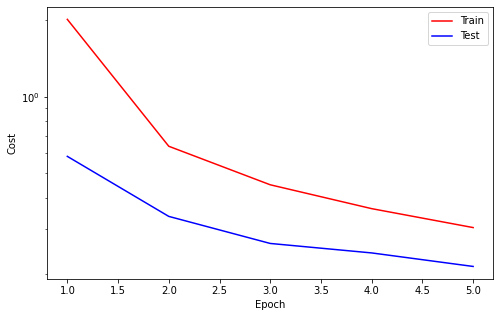

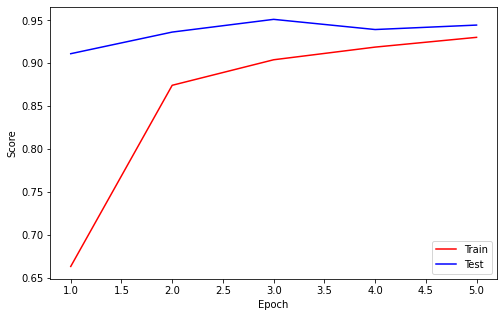

In [22]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [27]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5



Epoch     6
Train_cost  = 0.2821 | Test_cost  = 0.1623 | Train_score = 0.9407 | Test_score = 0.9689 |




Epoch     7
Train_cost  = 0.2184 | Test_cost  = 0.1440 | Train_score = 0.9560 | Test_score = 0.9696 |




Epoch     8
Train_cost  = 0.1933 | Test_cost  = 0.1283 | Train_score = 0.9614 | Test_score = 0.9741 |




Epoch     9
Train_cost  = 0.1736 | Test_cost  = 0.1220 | Train_score = 0.9659 | Test_score = 0.9733 |
==> EarlyStop patience =  1 | Best test_score: 0.9741




Epoch    10
Train_cost  = 0.1584 | Test_cost  = 0.1144 | Train_score = 0.9691 | Test_score = 0.9763 |




Epoch    11
Train_cost  = 0.1449 | Test_cost  = 0.1069 | Train_score = 0.9717 | Test_score = 0.9756 |
==> EarlyStop patience =  1 | Best test_score: 0.9763




Epoch    12
Train_cost  = 0.1327 | Test_cost  = 0.1045 | Train_score = 0.9757 | Test_score = 0.9748 |
==> EarlyStop patience =  2 | Best test_score: 0.9763




Epoch    13
Train_cost  = 0.1251 | Test_cost  = 0.1001 | Train_score = 0.9769 | Test_score = 0.9778 |




Epoch    14
Train_cost  = 0.1161 | Test_cost  = 0.0980 | Train_score = 0.9794 | Test_score = 0.9733 |
==> EarlyStop patience =  1 | Best test_score: 0.9778




Epoch    15
Train_cost  = 0.1075 | Test_cost  = 0.0973 | Train_score = 0.9821 | Test_score = 0.9778 |
==> EarlyStop patience =  2 | Best test_score: 0.9778




Epoch    16
Train_cost  = 0.1025 | Test_cost  = 0.0920 | Train_score = 0.9814 | Test_score = 0.9793 |




Epoch    17
Train_cost  = 0.0947 | Test_cost  = 0.0890 | Train_score = 0.9846 | Test_score = 0.9822 |




Epoch    18
Train_cost  = 0.0895 | Test_cost  = 0.0886 | Train_score = 0.9851 | Test_score = 0.9800 |
==> EarlyStop patience =  1 | Best test_score: 0.9822




Epoch    19
Train_cost  = 0.0821 | Test_cost  = 0.0866 | Train_score = 0.9870 | Test_score = 0.9800 |
==> EarlyStop patience =  2 | Best test_score: 0.9822




Epoch    20
Train_cost  = 0.0793 | Test_cost  = 0.0842 | Train_score = 0.9872 | Test_score = 0.9800 |


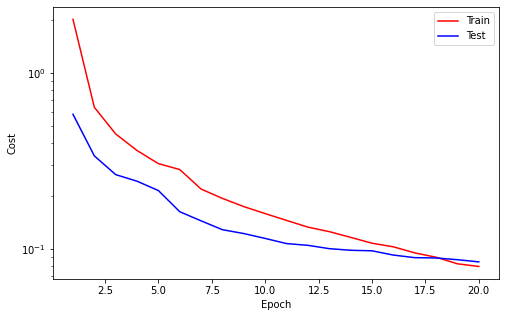

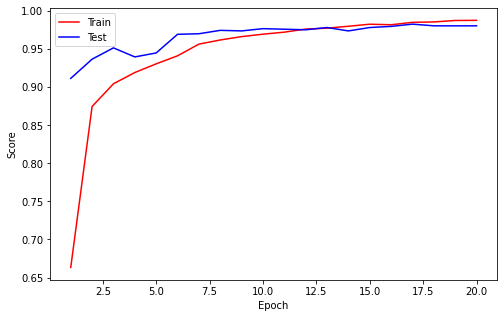

==> EarlyStop patience =  3 | Best test_score: 0.9822




Epoch    21
Train_cost  = 0.0753 | Test_cost  = 0.0813 | Train_score = 0.9883 | Test_score = 0.9770 |
==> EarlyStop patience =  4 | Best test_score: 0.9822




Epoch    22
Train_cost  = 0.0704 | Test_cost  = 0.0791 | Train_score = 0.9898 | Test_score = 0.9815 |
==> EarlyStop patience =  5 | Best test_score: 0.9822
==> Execute Early Stopping at epoch: 22 | Best test_score: 0.9822
==> Best model is saved at model


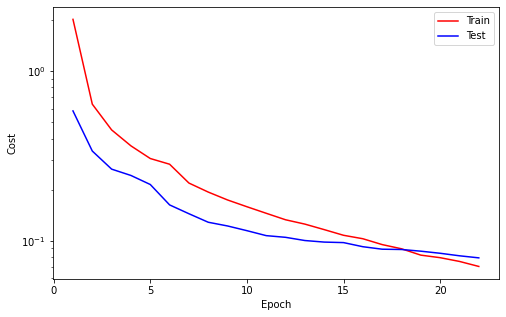

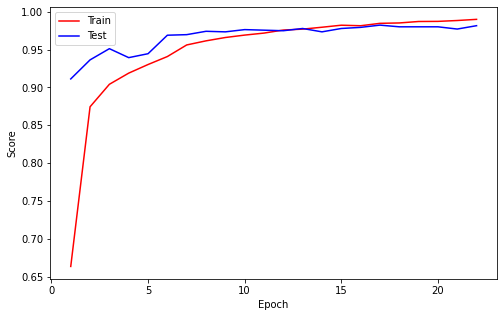

In [28]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [43]:
accuracy = []
for feature, target in valloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
    if(target == preds):
      acc = 1
    else: acc = 0
    accuracy.append(acc)

In [44]:
accuracy = np.array(accuracy)
accuracy.mean()

0.9896296296296296

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

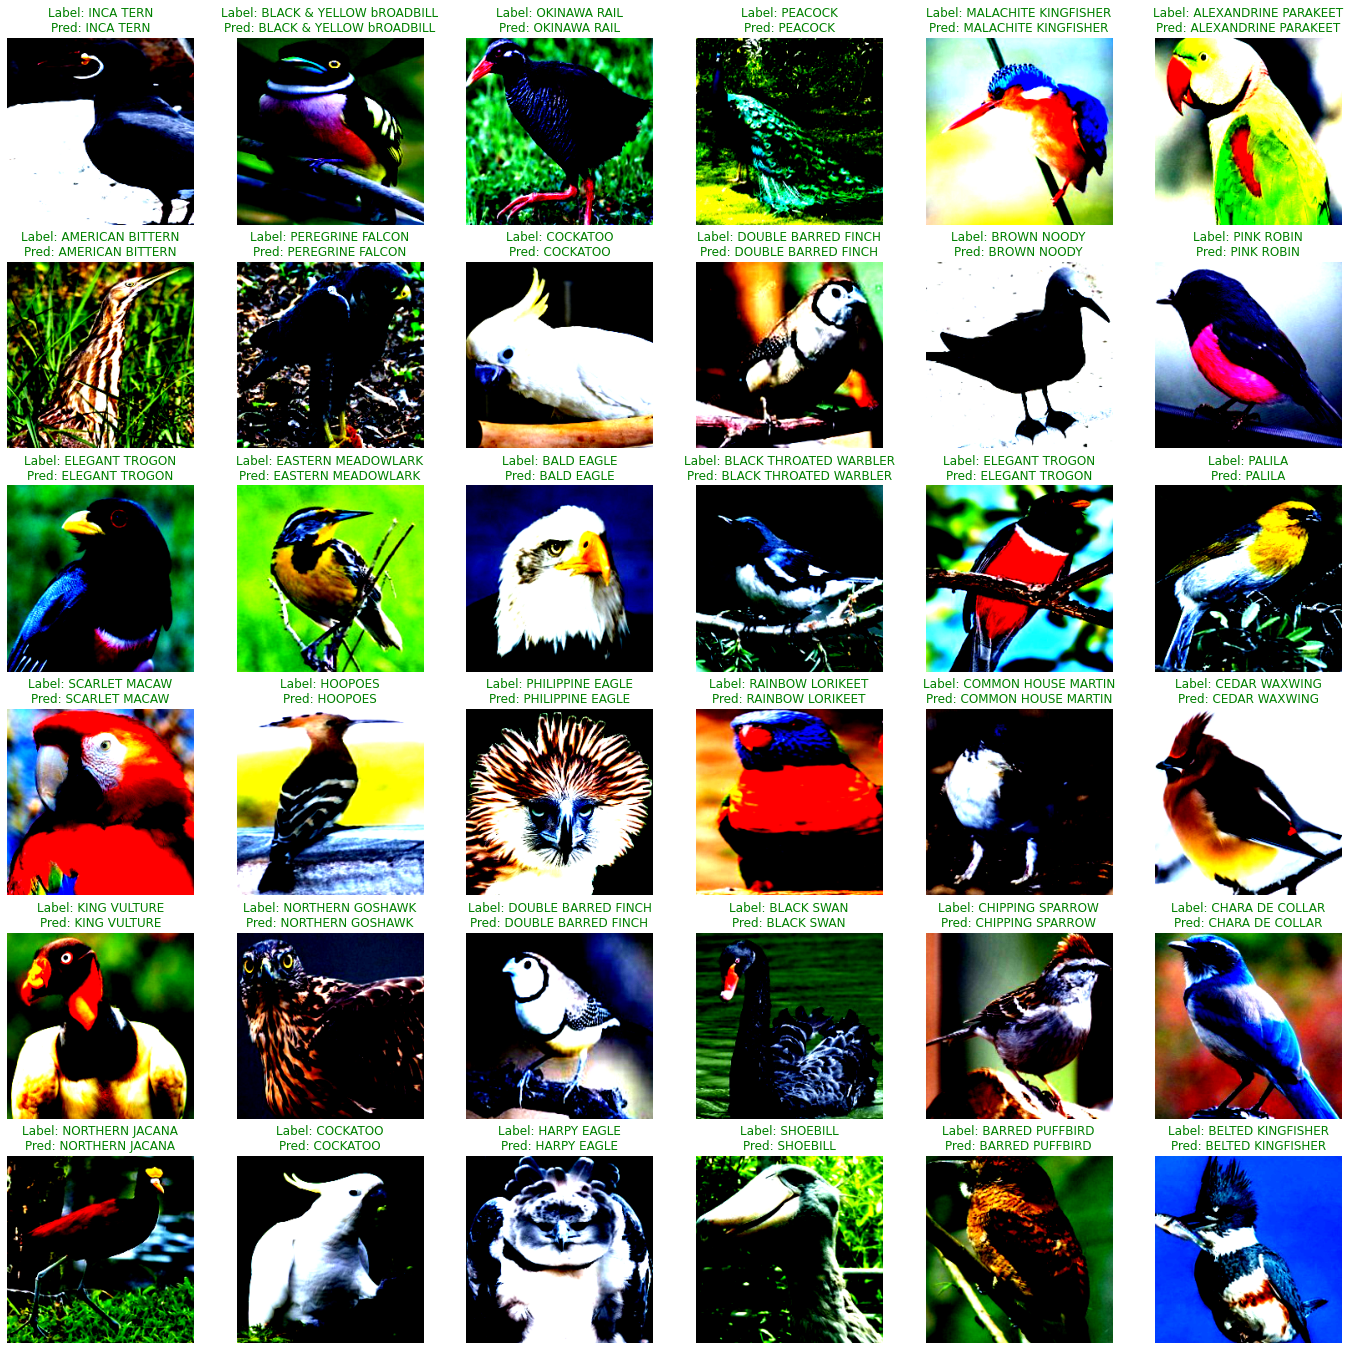

In [45]:
for feature, target in testloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.permute(1,2,0).cpu())
  font = {"color":'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
  ax.axis("off");